#### In this mini-project we will apply Transfer Learning to see if we can increase training accuracy for Horses v Humans. 
#### To avoid crazy overfitting, our validation set accuracy should be around 95% if done right! 
#### The training should automatically stop once it reaches this desired accuracy.

In [2]:
# import required libraries
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
from tensorflow.keras.applications.inception_v3 import InceptionV3  # Import the inception model  
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Construct the file path to the pre-trained weights file for the InceptionV3 model
path_inception = f"{getcwd()}/dataset/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
local_weights_file = path_inception
# Initialize the InceptionV3 model without the top fully connected layers and with a specific input shape
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = None)
# Load the pre-trained weights into the model from the specified file
pre_trained_model.load_weights(local_weights_file)

# Make all layers in the pre-trained model non-trainable to prevent their weights from being updated during training
for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [5]:
# Retrieve a specific layer from the pre-trained model
last_layer = pre_trained_model.get_layer('mixed7')
# Print the output shape of the retrieved layer to understand its dimensions
print('last layer output shape: ', last_layer.output_shape)
# Assign the output of the retrieved layer to a variable for further processing
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True   

In [8]:
x = layers.Flatten()(last_output)                  # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x)       # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x)                         # Add a dropout rate of 0.2       
x = layers.Dense (1, activation='sigmoid')(x)      # Add a final sigmoid layer for classification      
# Create a new model using the input of the pre-trained model and the new top layers
model = Model( pre_trained_model.input, x) 
# Compile the model with specific settings
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

Extract image data from zipfile

In [9]:
# Get the Horse or Human dataset
path_horse_or_human = f"{getcwd()}/dataset/horse-or-human.zip"

# Get the Horse or Human Validation dataset
path_validation_horse_or_human = f"{getcwd()}/dataset/validation-horse-or-human.zip"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# shutil.rmtree('/h-h_dataset')
local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('h-h_dataset/train')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('h-h_dataset/validation')
zip_ref.close()

In [10]:
# Define directory paths for training and validation data
train_dir = 'h-h_dataset/train'
validation_dir = 'h-h_dataset/validation'

# Define subdirectory paths for horses and humans within the training and validation directories
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Get lists of filenames in each directory
train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

# Print the number of files in each category to understand the dataset distribution
print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [12]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [20]:
# Define an instance of the custom callback class
callbacks = myCallback()

# Initiate model training
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  
      epochs=3,
      verbose=2,
      callbacks = [callbacks],
      validation_data = validation_generator,
      validation_steps=3)

Epoch 1/3
10/10 - 13s - loss: 0.0912 - acc: 0.9500 - val_loss: 0.0171 - val_acc: 1.0000
Epoch 2/3

Reached 97.0% accuracy so cancelling training!
10/10 - 12s - loss: 0.0200 - acc: 0.9900 - val_loss: 0.0125 - val_acc: 1.0000


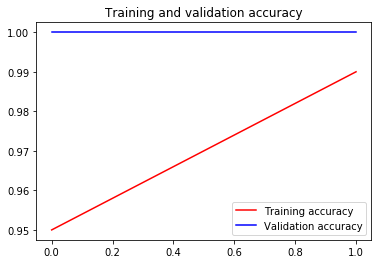

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot accuracy and loss plots
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()